# Описание проекта

**Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.**

   **Задача:**   
   **Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC.**

In [1]:
!pip install -U -q catboost
!pip install -U -q seaborn

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

from time import time

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter('ignore')

from tqdm.notebook import tqdm
tqdm.pandas()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# округляем значения до трех знаков после запятой
pd.options.display.float_format = '{:.8f}'.format

PATH_ORDERS='/content/gdrive/MyDrive/REPETIT/orders.feather'
PATH_PREFERRED_TEACHERS_ORDER='/content/gdrive/MyDrive/REPETIT/prefered_teachers_order_id.feather'
PATH_SUITABLE_TEACHERS='/content/gdrive/MyDrive/REPETIT/suitable_teachers.feather'
PATH_TEACHERS_INFO='/content/gdrive/MyDrive/REPETIT/teachers_info.feather'
STATE = 42 #Random state
# за дату отсчёта возмём 31 декабря 2023
DATE_FINAL = '2023-12-31'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sklearn; sklearn.show_versions()


System:
    python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.58+-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.2.2
          pip: 23.1.2
   setuptools: 67.7.2
        numpy: 1.25.2
        scipy: 1.11.4
       Cython: 3.0.8
       pandas: 1.5.3
   matplotlib: 3.7.1
       joblib: 1.3.2
threadpoolctl: 3.3.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 2
         prefix: libopenblas
       filepath: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: Haswell

       user_api: blas
   internal_api: openblas
    num_threads: 2
         prefix: libopenblas
       filepath: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-23e5df77.3.21.dev.so
        version: 0.3.21.dev
threading_layer: pthreads
   architecture: Haswell

    

In [4]:
df_orders = pd.read_feather(PATH_ORDERS)

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

In [6]:
df_orders.head(4)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.00000000,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.00000000,675960,7.00000000,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.00000000,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.00000000,675960,7.00000000,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.00000000,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.00000000,16,None,NaN,0,7,None,NaN,14.00000000,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.00000000,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.00000000,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.00000000,16,None,NaN,0,10,None,47749.00000000,10.00000000,3,0,3,5,0,4,0,20,90,0,0,14,2293804.00000000,1024340,17.00000000,NaN,2310,None,1


In [7]:
# для удобства напишем функцию для просмотра информации о датафрейме
def description(df):
    print('Размер фрейма', df.shape)
    frame = df.dtypes.to_frame(name='Тип данных')
    frame['Кол-во пропусков'] = df.isna().sum()
    frame['Процент пропусков'] = df.isna().mean() * 100
    frame['Кол-во уникальных'] = df.nunique()
    frame['MIN'] = df.min()
    frame['Min_thresh'] = df.quantile(.25) - ((df.quantile(.75) - df.quantile(.25)) * 1.5)
    frame['Медиана'] = df.median()
    frame['MAX'] = df.max()
    frame['Max_thresh'] = df.quantile(.75) + ((df.quantile(.75) - df.quantile(.25)) * 1.5)
    frame['STD'] = df.std()
    return frame

In [8]:
description(df_orders)

Размер фрейма (1191861, 38)


,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Min_thresh,Медиана,MAX,Max_thresh,STD
id,int32,0,0.00000000,1190961,1742636,1145522.50000000,2341556.00000000,3605505,3534638.50000000,344556.25455897
order_date,object,0,0.00000000,1190749,0029-07-18 05:28:02.684,NaN,NaN,2023-11-05 23:59:45.687,NaN,NaN
subject_id,float32,10332,0.86687961,30,1.00000000,-12.00000000,8.00000000,3605505.00000000,28.00000000,6157.33300781
purpose,object,166510,13.97058885,294447,NaN,NaN,NaN,NaN,NaN,NaN
lesson_price,int32,0,0.00000000,349,0,-1000.00000000,1000.00000000,1000000000,3000.00000000,916334.05336593
lesson_duration,int32,0,0.00000000,9,0,60.00000000,60.00000000,3605505,60.00000000,6130.49378564
lesson_place,object,1191830,99.99739903,4,NaN,NaN,NaN,NaN,NaN,NaN
home_metro_id,float32,549414,46.09715395,2326,1.00000000,-1149.00000000,644.00000000,3605505.00000000,2523.00000000,8375.08203125
add_info,object,147173,12.34816812,609437,NaN,NaN,NaN,NaN,NaN,NaN
start_date,object,486283,40.80031145,705033,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_orders.order_date.is_monotonic

False

In [10]:
# Проверим индексы
df_orders.index.nunique()

437217

**У нас имеются довольно странные значения, почти во всех столбцах. Посмотрим на них.**

### pupil_knowledgelvl

In [11]:
df_orders[df_orders['pupil_knowledgelvl'] == 3605505]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
437216,3605505,0029-07-18 05:28:02.684,3605505.00000000,None,3605505,3605505,None,3605505.00000000,None,0029-07-18 05:28:02.684,3605505.00000000,3605505,None,3605505.00000000,"4,450342944189884E-308",3605505,0029-07-18 05:28:02.684,3605505.00000000,3605505.00000000,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.00000000,3605505,3605505.00000000,3605505.00000000,"4,450342944189884E-308",0029-07-18 05:28:02.684,1


In [12]:
df_orders['pupil_knowledgelvl'].value_counts()

0          947390
2          105457
1           85426
3           46855
4            6729
3211265         2
3342337         1
3605505         1
Name: pupil_knowledgelvl, dtype: int64

### purpose и add_info

In [13]:
df_orders.loc[407875, 'purpose']

'\n\u200bЦель занятий : Главная цель - начать говорить на английском. Далее хочу развить навык для выхода на европейский рынок труда.\u200a\n\u200bКатегория ученика : Взрослый\u200a'

In [14]:
df_orders.loc[407875, 'add_info']

'\n\u200bСвободное время : Понедельник-утро,Вторник-утро,Четверг-утро,Пятница-утро\u200a\n\u200bТребования к репетитору : Не готовы заниматься с репетитором-студентом\u200a\n\u200bВозраст репетитора : До 30 лет\u200a\n\u200bДополнительные пожелания : Было бы идеально, если бы занятия проходили в рамках учебника типа American English File и только на английском языке\u200a'

In [15]:
# функция для очистки текста
def clean_text(text):

    text = re.sub(r'[\u200a]', ' ', text)
    text = re.sub(r'[^а-яёА-ЯЁa-zA-Z0-9\-]', ' ', text)

    return ' '.join(text.split())

In [16]:
clean_text(df_orders.loc[407875, 'purpose'])

'Цель занятий Главная цель - начать говорить на английском Далее хочу развить навык для выхода на европейский рынок труда Категория ученика Взрослый'

In [17]:
clean_text(df_orders.loc[407875, 'add_info'])

'Свободное время Понедельник-утро Вторник-утро Четверг-утро Пятница-утро Требования к репетитору Не готовы заниматься с репетитором-студентом Возраст репетитора До 30 лет Дополнительные пожелания Было бы идеально если бы занятия проходили в рамках учебника типа American English File и только на английском языке'

### Дубликаты

In [18]:
# посмотрим есть ли дубликаты строк
df_orders.duplicated().sum()

900

In [19]:
df_orders[df_orders.duplicated(keep=False)].sort_values('id').head(2)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
104493,2398558,2023-01-07 00:00:12.137,19.00000000,Разделы: вокал.\nКатегория ученика: парень 27 ...,1200,60,None,1630.00000000,Район: г. Кондрово.\nМесто проведения занятий:...,2023-01-07 12:17:22.070,47053.00000000,14,None,NaN,300,10,None,NaN,15.00000000,3,0,3,0,0,4,1,0,0,0,0,23,NaN,1062677,21.00000000,NaN,3240,None,1
0,2398558,2023-01-07 00:00:12.137,19.00000000,Разделы: вокал.\nКатегория ученика: парень 27 ...,1200,60,None,1630.00000000,Район: г. Кондрово.\nМесто проведения занятий:...,2023-01-07 12:17:22.070,47053.00000000,14,None,NaN,300,10,None,NaN,15.00000000,3,0,3,0,0,4,1,0,0,0,0,23,NaN,1062677,21.00000000,NaN,3240,None,1


### lesson_price

**Хотя на сайте стоит максимальная цена за урок 5000,
я нашёл репетиторов со стоимостью 6000, 7000, 9000. Максимальная цена от 10000 руб/час (два человека)**

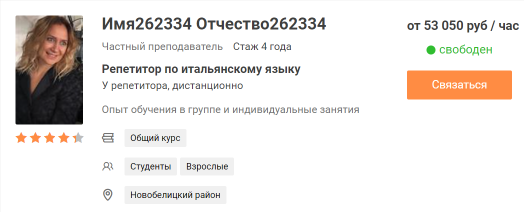

**этого не считаем)))**

### lesson_duration

In [20]:
df_orders.lesson_duration.value_counts()

60         1136516
90           25638
45           19914
120           7211
0             2386
135            192
3211265          2
3342337          1
3605505          1
Name: lesson_duration, dtype: int64

### teacher_sex

0. Неизвестно
1. Мужчина   
2. Женщина  

In [21]:
df_orders.teacher_sex.value_counts()

3          549812
2          392286
0          203697
1           46062
3211265         2
3342337         1
3605505         1
Name: teacher_sex, dtype: int64

**700000 значений не известен пол, вряд ли он нам пригодится.**

### совпадающие id и original_order_id

In [22]:
# посмотрим имеются ли строки с совпадающими id и original_order_id
df_orders[df_orders.id == df_orders.original_order_id]['id'].count()

852

In [23]:
df_orders[df_orders.id == df_orders.original_order_id].head(2)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
1016,2295070,2022-11-01 15:07:53.233,21.00000000,None,0,60,None,NaN,Дополнительная информация:\r\nИзучаемый предме...,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,8,2295070.00000000,1024766,7.00000000,NaN,None,None,1
3190,2297244,2022-11-02 16:59:27.860,2.00000000,None,0,60,None,NaN,None,None,NaN,7,Тестовая группа : SplitTestA\n02.11.2022 17:25...,NaN,0,0,None,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,16,2297244.00000000,950620,7.00000000,NaN,None,None,1


In [24]:
set(df_orders[df_orders.id == df_orders.original_order_id]['id']) == set(df_orders[df_orders.id == df_orders.original_order_id]['original_order_id'])

True

### minimal_price

In [25]:
# минимальная цена не может быть выше максимальной (5000)
# может быть цена от 5000 до 5000 (фиксированная)
df_orders[df_orders.minimal_price > 5000]['id'].count()

385

### Дубли без оригинала

**У нас имеются дубликаты у которых отсутствует оригинальная заявка, то есть original_order_id ссылается на несуществующую заявку.**

In [26]:
# функция для удаления дублей без оригинала
'''
Делаю через цикл, потому что после первого удаления остаются
дубликаты этих заявок. Например, есть строка, у которой в original_order_id
стоит значение 777 (допустим) и у неё нет оригинальной заявки.
Но есть её дубликаты с id = 777 и после первого удаления они останутся.
'''
def dup_without_original(data):
    df = data.copy()

    print('Удаляем дубли для которых нет оригинальной заявки...')
    flag = True
    while flag:
        # фрейм с дублями
        dub_ord_df = df[df.original_order_id.notna()]
        # индексы дублей у которой нет оригинальной заявки
        idx_no_original = dub_ord_df[~dub_ord_df['original_order_id'].isin(df.id)].index
        # удалим эти строки
        df.drop(index=idx_no_original, inplace=True)
        print(f'Удалено {len(idx_no_original)} строк(и).')
        if len(idx_no_original) == 0:
            flag = False
    print()

    return df

### teacher_experience_to и teacher_experience_from

In [27]:
df_orders.teacher_experience_to.value_counts().head()

0      1174653
100       4901
50        3428
10        1934
60        1457
Name: teacher_experience_to, dtype: int64

**Учитывая, что почти все значения нулевые, удалим эти столбцы**

### teacher_age_to и teacher_age_from

**в столбцах teacher_age_to и teacher_age_from исправим отрицательные значения**

In [28]:
df_orders[df_orders['teacher_age_to'] < 0]['teacher_age_to'].value_counts()

-50     3
-10     1
-2      1
-110    1
-60     1
-65     1
Name: teacher_age_to, dtype: int64

### Удаление дублей с датой раньше оригинальной

**Пример:**

In [29]:
tmp_df = df_orders[df_orders['client_id'] == 1268503].sort_values(['client_id', 'order_date'])[['id', 'order_date', 'original_order_id', 'client_id']]
tmp_df

,id,order_date,original_order_id,client_id
348372,2936387,2023-11-05 19:36:36.527,2936390.00000000,1268503
348375,2936390,2023-11-05 19:38:42.373,NaN,1268503
348392,2936407,2023-11-05 19:53:32.490,2936390.00000000,1268503


**Мы видим, что дата создания дубля заявки (строки с индексом 1191562) создана раньше оригинала.**

In [30]:
# функция для удаления дублей с датой раньше оригинальной
def del_dup_date_earlier_original(data):
    df = data.copy()

    print("Удаляем дубли с датой раньше оригинальной...")
    incor_dup_idx = df[df['original_order_id'].notna() & (df['order_date'] < df['original_order_id']
                                                                             .map(df.set_index('id')['order_date']))].index
    df.drop(index=incor_dup_idx, inplace=True)
    print(f'Было удалено {len(incor_dup_idx)} строк(и).')
    print()

    return df

In [31]:
del_dup_date_earlier_original(tmp_df)

Удаляем дубли с датой раньше оригинальной...
Было удалено 1 строк(и).



,id,order_date,original_order_id,client_id
348375,2936390,2023-11-05 19:38:42.373,NaN,1268503
348392,2936407,2023-11-05 19:53:32.490,2936390.00000000,1268503


### Дубликаты дубликатов

In [32]:
df_orders.sort_values(['client_id', 'order_date'])[['id', 'order_date', 'original_order_id', 'client_id']].head(20)

,id,order_date,original_order_id,client_id
230059,2073301,2022-06-01 01:00:45.017,NaN,1
26273,2504890,2023-02-28 13:01:28.767,NaN,1
26279,2504896,2023-02-28 13:06:14.050,2504890.00000000,1
26282,2504899,2023-02-28 13:07:52.817,2504890.00000000,1
26284,2504901,2023-02-28 13:07:55.423,2504890.00000000,1
26285,2504902,2023-02-28 13:07:57.970,2504890.00000000,1
26286,2504903,2023-02-28 13:08:01.493,2504890.00000000,1
26287,2504904,2023-02-28 13:08:05.070,2504890.00000000,1
26288,2504905,2023-02-28 13:08:08.230,2504890.00000000,1
26289,2504906,2023-02-28 13:08:11.910,2504890.00000000,1


**У нас имеются дубликаты дубликатов. То есть строка с заказом 2504911(индекс 26294) является дубликатом заказа 2504907(индекс 26290), которая в свою очередь является дубликатом заказа 2504890 (индекс 26273).**

**Для примера я создам датафрейм**

In [33]:
# Пример данных
data = {
    'index': [340, 358, 359, 361, 363, 439, 442, 447, 449, 33664, 33670, 33673, 33674, 33675, 33676, 33677, 33678],
    'id': [1742973, 1742991, 1742992, 1742994, 1742996, 1743072, 1743075, 1743080, 1743082, 1776595, 1776601, 1776604, 1776605, 1776606, 1776608, 1776609, 1776610],
    'original_order_id': [np.nan, 1742973.0, 1742991.0, 1742992.0, 1742991.0, 1742973.0, 1742973.0, 1742973.0, 1742973.0, np.nan, 1776595.0, 1776595.0, np.nan, 1776605, np.nan, 1776608, 1776609],
    'client_id': [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 222, 222, 333, 333, 333]
}

df = pd.DataFrame(data)
df = df.set_index('index')

In [34]:
df

,id,original_order_id,client_id
index,,,
340,1742973,NaN,111
358,1742991,1742973.00000000,111
359,1742992,1742991.00000000,111
361,1742994,1742992.00000000,111
363,1742996,1742991.00000000,111
439,1743072,1742973.00000000,111
442,1743075,1742973.00000000,111
447,1743080,1742973.00000000,111
449,1743082,1742973.00000000,111


**В данном примере у нас два уровня:**   
- строка 358 является дублем оригинала (заявка 1742973)   
- строка 359 является дублем заявки 1742991, которая является дублем оригинала (заявка 1742973)   
- строка 361 является дублем заявки 1742992, которая является дублем 1742991, которая является дублем оригинала (заявка 1742973)  

Вообщем и так далее)))

In [35]:
# функция для замены дубликатов дубликатов на номер оригинальной заявки на одном уровне
def replace_dub(data):
    l_or = []
    l_dup = {}
    df = data.copy()
    for i, row in tqdm(df.iterrows()):
        if pd.isna(row['original_order_id']):
            l_or.append(row['id'])
        else:
            if row['original_order_id'] in l_or:
                    l_dup[row['id']] = row['original_order_id']
    tmp_df = df.copy()
    tmp_df['original_order_id'] = tmp_df['original_order_id'].map(l_dup)
    tmp_df = tmp_df[tmp_df['original_order_id'].notna()]
    print(f'Заменено {tmp_df.shape[0]} значений(я).')
    df.loc[tmp_df.index, 'original_order_id'] = tmp_df.loc[tmp_df.index, 'original_order_id']

    return df

In [36]:
# функция для замены дубликатов дубликатов на номер оригинальной заявки на всех уровнях
def cycle_replace_dub(data):
    df = data.copy()

    print('Меняем дубликаты дубликатов на номер оригинальной заявки')
    dub_ord_df = df[df.original_order_id.notna()]   # дубли
    flag = True
    while flag:
        # фрейм с дубликатами дубликатов
        df_dup_dup = df[df.original_order_id.isin(dub_ord_df.id)]
        # создаём список клиентов у которых есть дубликаты дубликатов заявок
        lst_client_id_dub = df_dup_dup['client_id'].unique().tolist()
        # print('Количество клиентов для которых будет произведена замена', len(lst_client_id_dub))
        # print('Количество строк для работы', df[df['client_id'].isin(lst_client_id_dub)].shape[0])
        print('Количество строк для обработки', df_dup_dup.shape[0])
        prew_val = df_dup_dup.shape[0]
        # применяем функцию к фрейму из списка клиентов
        df[df['client_id'].isin(lst_client_id_dub)] = replace_dub(df[df['client_id'].isin(lst_client_id_dub)])
        df_dup_dup = df[df.original_order_id.isin(dub_ord_df.id)]
        # если значения перестали менятся
        if prew_val == df_dup_dup.shape[0]:
            flag = False
        # оставшиеся строки просто удалим
    df.drop(index=df_dup_dup.index, inplace=True)
    print(f'Удалено {len(df_dup_dup.index)} строк(и)')
    print()

    return df

**Пример работы функции.**

In [37]:
cycle_replace_dub(df)

Меняем дубликаты дубликатов на номер оригинальной заявки
Количество строк для обработки 4


0it [00:00, ?it/s]

Заменено 3 значений(я).
Количество строк для обработки 1


0it [00:00, ?it/s]

Заменено 1 значений(я).
Количество строк для обработки 0


0it [00:00, ?it/s]

Заменено 0 значений(я).
Удалено 0 строк(и)



,id,original_order_id,client_id
index,,,
340,1742973,NaN,111
358,1742991,1742973.00000000,111
359,1742992,1742973.00000000,111
361,1742994,1742973.00000000,111
363,1742996,1742973.00000000,111
439,1743072,1742973.00000000,111
442,1743075,1742973.00000000,111
447,1743080,1742973.00000000,111
449,1743082,1742973.00000000,111


### target

In [38]:
def create_target(data):
    df = data.copy()

    print('Создание таргета')
    # Создадим два фрейма с оригинальными заявками и с дублями
    orig_ord_df = df[df.original_order_id.isna()]   # оригинал
    dub_ord_df = df[df.original_order_id.notna()]   # дубли
    # список id оригинальных заявоК, у которых status_id 5, 6, 13, 15
    ord_id = orig_ord_df[orig_ord_df['status_id'].isin({5, 6, 13, 15})]['id'].tolist()
    print(f'Список id оригинальных заявок {len(ord_id)} строк(и).')
    # список id из original_order_id, у которых status_id 5, 6, 13, 15
    ord_original_order_id = dub_ord_df[dub_ord_df['status_id'].isin({5, 6, 13, 15})]['original_order_id'].tolist()
    print(f'список id из original_order_id {len(ord_original_order_id)} строк(и).')
    # общий список
    all_id = list(set(ord_id + ord_original_order_id))
    print(f'общий список {len(all_id)} строк(и).')
    # получим список индексов строк, id которых либо в id, либо в original_order_id
    idx_targ_1 = (df[(df['id'].isin(all_id)) | (df['original_order_id'].isin(all_id))]).index.tolist()
    print(f'Длина список индексов строк, id которых либо в id, либо в original_order_id {len(idx_targ_1)} строк(и).')
    # создаём столбец target
    df['target'] = 0
    # заполним единицами, по индексам из списка
    df.loc[idx_targ_1, 'target'] = 1
    print(df['target'].value_counts())
    print()

    return df

### Оптимизация данных

In [3]:
# функция для оптимизации данных
def reduce_mem_usage(df):

    print('Оптимизируем данные...')
    start_mem = df.memory_usage().sum() / 1024**2
    print('До обработки памяти использовано {:.2f} MB'.format(start_mem))

    col_int = df.select_dtypes(include=int).columns
    col_float = df.select_dtypes(include=float).columns

    df[col_int] = df[col_int].progress_apply(pd.to_numeric, downcast='integer')
    df[col_float] = df[col_float].progress_apply(pd.to_numeric, downcast='float')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'После оптимизации памяти использовано: {end_mem:.2f} MB')
    print(f'Использование памяти уменьшилось на {100 * (start_mem - end_mem) / start_mem:.1f}%')
    print()

    return df

### Столбцы для удаления

In [40]:
# создадим список столбцов для удаления
col_drop = ['start_date',            # эти столбцы мы не знаем на момент подачи заявки
            'estimated_fee',
            'working_teacher_id',
            'additional_status_id',
            'status_id',
            'amount_to_pay',
            'teacher_experience_to',   # а некоторые малоинформативные
            'teacher_experience_from',
            'teacher_sex',
            'order_date']

### Функция для препроцессинга df_orders

In [41]:
def preprocessing_order(data, col_drop):

    df = data.copy()

    before = df.shape[0]

    # отсортируем фрейм по дате
    df.sort_values('order_date', inplace=True)
    # сбросим индексы
    df = df.reset_index(drop=True)
    # удалим эти четыре строки
    df = df[df['pupil_knowledgelvl'] < 5]
    # исправим сразу формат даты и округлим до секунд
    df['order_date'] = pd.to_datetime(df['order_date']).dt.round('S')

    # заполним пропуски пустой строкой
    df['purpose'] = df['purpose'].fillna('')
    df['add_info'] = df['add_info'].fillna('')
    # очистим текст
    print('Выполнение очистки текста purpose и add_info.')
    df['purpose'] = df['purpose'].progress_apply(clean_text)
    df['add_info'] = df['add_info'].progress_apply(clean_text)
    print()
    print(f'Удалено {df.duplicated().sum()} дубликатов строк.')
    print()
    # удалим дубликаты
    df.drop_duplicates(inplace=True)
    # вряд ли имеют смысл строки в которых пропущены значения предмета обучения
    # непонятно чему обучать и кем))) удалим эти строки
    df = df[df.subject_id.notna()]
    # создадим список столбцов со 70% пропусками
    col_na_70 = [col for col in df.columns if df[col].isna().mean() > 0.7]
    col_drop.extend(col_na_70)
    # удалим из lesson_price уроки стоимостью более 10000
    print(f'Удалено из lesson_price', df[df.lesson_price > 10000]['id'].count(), 'строк(и).')
    df = df[df.lesson_price <= 10000]
    # совпадающие id и original_order_id
    # заменим значение в original_order_id на NaN, как в оригинальных заявках
    df.loc[df.id == df.original_order_id, 'original_order_id'] = np.nan
    # удалим из minimal_price строки со стоимостью выше максимальной (5000)
    print(f'Удалено из minimal_price', df[df.minimal_price > 5000]['id'].count(), 'строк(и).\n')
    df = df[df.minimal_price <= 5000]
    # в столбцах teacher_age_to и teacher_age_from исправим отрицательные значения
    df[['teacher_age_to', 'teacher_age_from']] = df[['teacher_age_to', 'teacher_age_from']].abs()

    # создание столбцов
    # столбец является ли заявка дубликатом или нет
    df['is_dub'] = df['original_order_id'].notna().astype(int)
    # столбец даты в цифровом варианте (григорианский порядковый номер даты)
    df['date_int'] = (df['order_date'].apply(lambda x: x.toordinal()))
    # время суток в часах, минутах, секундах
    df['time_int'] = df['order_date'].dt.hour + df['order_date'].dt.minute / 60 + df['order_date'].dt.second / 3600
    # ранг дубликатов (оригинальная - 0, остальные с порядковыми номерами по дате)
    df['rank_dub'] = df.groupby('original_order_id')['is_dub'].cumsum().fillna(0)
    # количество покупок клиентом
    count_purchase = df[df['original_order_id'].isna()].groupby('client_id')['id'].agg(count_purchase=('count'))
    df = df.merge(count_purchase, how='left', on='client_id')

    # удаление дублей без оригинала
    df = dup_without_original(df)

    # eдаление дублей с датой раньше оригинальной
    df = del_dup_date_earlier_original(df)

    # Дубликаты дубликатов
    df = cycle_replace_dub(df)

    # создание таргета
    df = create_target(df)

    # переименуем id в order_id
    df = df.rename(columns={'id': 'order_id'})
    # удалим ненужные столбцы
    print(f'Удалено {len(col_drop)} столбцов(а)')
    df.drop(columns=col_drop, inplace=True)

    # оптимизация данных
    df = reduce_mem_usage(df)

    after = df.shape[0]
    print(f'ВСЕГО УДАЛЕНО - {before - after} строк, {100 * (before - after) / before:.2f}% данных.')

    return df

In [42]:
df_orders = preprocessing_order(df_orders, col_drop)

Выполнение очистки текста purpose и add_info.


  0%|          | 0/1191857 [00:00<?, ?it/s]

  0%|          | 0/1191857 [00:00<?, ?it/s]


Удалено 899 дубликатов строк.

Удалено из lesson_price 729 строк(и).
Удалено из minimal_price 107 строк(и).

Удаляем дубли для которых нет оригинальной заявки...
Удалено 3152 строк(и).
Удалено 555 строк(и).
Удалено 58 строк(и).
Удалено 0 строк(и).

Удаляем дубли с датой раньше оригинальной...
Было удалено 17384 строк(и).

Меняем дубликаты дубликатов на номер оригинальной заявки
Количество строк для обработки 29024


0it [00:00, ?it/s]

Заменено 26428 значений(я).
Количество строк для обработки 2596


0it [00:00, ?it/s]

Заменено 1699 значений(я).
Количество строк для обработки 897


0it [00:00, ?it/s]

Заменено 32 значений(я).
Количество строк для обработки 865


0it [00:00, ?it/s]

Заменено 5 значений(я).
Количество строк для обработки 860


0it [00:00, ?it/s]

Заменено 0 значений(я).
Удалено 860 строк(и)

Создание таргета
Список id оригинальных заявок 85259 строк(и).
список id из original_order_id 41671 строк(и).
общий список 124866 строк(и).
Длина список индексов строк, id которых либо в id, либо в original_order_id 290666 строк(и).
0    867122
1    290666
Name: target, dtype: int64

Удалено 16 столбцов(а)
Оптимизируем данные...
До обработки памяти использовано 190.14 MB


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

После оптимизации памяти использовано: 131.62 MB
Использование памяти уменьшилось на 30.8%

ВСЕГО УДАЛЕНО - 34073 строк, 2.86% данных.


In [43]:
description(df_orders)

Размер фрейма (1157788, 28)


,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Min_thresh,Медиана,MAX,Max_thresh,STD
order_id,int32,0,0.00000000,1157788,1742636,1148862.00000000,2339843.50000000,2936685,3529632.00000000,343701.95105023
subject_id,float32,0,0.00000000,27,1.00000000,-12.00000000,8.00000000,36.00000000,28.00000000,7.65578842
purpose,object,0,0.00000000,269840,,NaN,NaN,языковая школа просит продолжить поиск,NaN,NaN
lesson_price,int16,0,0.00000000,273,0,-1000.00000000,1000.00000000,10000,3000.00000000,897.34367655
lesson_duration,int16,0,0.00000000,6,0,60.00000000,60.00000000,135,60.00000000,7.16596656
home_metro_id,float32,527763,45.58373381,2321,1.00000000,-1171.50000000,644.00000000,2704.00000000,2560.50000000,670.30957031
add_info,object,0,0.00000000,587172,,NaN,NaN,ясенево студ,NaN,NaN
planned_lesson_number,int8,0,0.00000000,5,0,10.00000000,10.00000000,10,10.00000000,3.46793086
creator_id,float32,588729,50.84946467,106847,45.00000000,-692470.00000000,780665.00000000,1333433.00000000,1966410.00000000,400741.50000000
pupil_category_new_id,float32,143672,12.40918026,16,1.00000000,2.00000000,10.00000000,17.00000000,18.00000000,3.66228390


# suitable_teachers

In [44]:
df_suitable_teachers = pd.read_feather(PATH_SUITABLE_TEACHERS)

In [45]:
df_suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


In [46]:
df_suitable_teachers.head(10)

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1
5,238654,1742714,",",0,0
6,155227,1742714,",",0,0
7,5244,1742714,",",0,0
8,145485,1742714,",",0,0
9,163724,1742714,",",0,0


In [47]:
description(df_suitable_teachers)

Размер фрейма (20271186, 5)


,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Min_thresh,Медиана,MAX,Max_thresh,STD
teacher_id,int32,0,0.00000000,145944,33.00000000,-97709.50000000,159595.00000000,312661.00000000,417302.50000000,80246.76491069
order_id,int32,0,0.00000000,842019,1742638.00000000,1495802.00000000,2571756.00000000,2946699.00000000,3548922.00000000,333894.03215900
contact_result,category,12824362,63.26399452,10866,NaN,NaN,NaN,NaN,NaN,NaN
enable_auto_assign,int8,0,0.00000000,2,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.33531976
enable_assign,int8,0,0.00000000,2,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.16367427


In [48]:
def suitable_teachers_preprocessing(data):
    df = data.copy()

    # удаление дубликатов
    print(f'Количество дубликатов {df.duplicated().sum()} строк(и).')
    df.drop_duplicates(inplace=True)
    print('Удалено.')
    # удалим столбец contact_result, так как его нет при приёме заявки
    df.drop(columns='contact_result', inplace=True)
    print('Удалён столбец contact_result.')

    return df

In [49]:
df_suitable_teachers = suitable_teachers_preprocessing(df_suitable_teachers)

Количество дубликатов 49 строк(и).
Удалено.
Удалён столбец contact_result.


# teachers_info

In [50]:
df_teachers_info = pd.read_feather(PATH_TEACHERS_INFO)

In [51]:
df_teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

In [52]:
description(df_teachers_info)

Размер фрейма (307972, 80)


,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Min_thresh,Медиана,MAX,Max_thresh,STD
id,int32,0,0.00000000,307972,33.00000000,-154674.50000000,157384.50000000,312622.00000000,469499.50000000,90198.00546274
date_update,category,0,0.00000000,307079,NaN,NaN,NaN,NaN,NaN,NaN
reg_date,category,0,0.00000000,307729,NaN,NaN,NaN,NaN,NaN,NaN
birth_date,category,0,0.00000000,22247,NaN,NaN,NaN,NaN,NaN,NaN
teaching_start_date,category,0,0.00000000,776,NaN,NaN,NaN,NaN,NaN,NaN
user_id,int32,0,0.00000000,307972,45.00000000,-1017249.00000000,431489.00000000,1334900.00000000,1910569.00000000,401910.75714060
is_email_confirmed,int8,0,0.00000000,2,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.11211433
is_home_lessons,int8,0,0.00000000,2,0.00000000,-1.50000000,0.00000000,1.00000000,2.50000000,0.49383968
is_external_lessons,int8,0,0.00000000,2,0.00000000,-1.50000000,1.00000000,1.00000000,2.50000000,0.49007242
external_comments,category,216994,70.45900277,26082,NaN,NaN,NaN,NaN,NaN,NaN


**Мы видим абсолютно неадекватные даты. Твкже отклонения в lesson_cost и lesson_duration. Далее посмотрим)))**

In [53]:
# исправим сразу формат даты
for i in ['birth_date', 'teaching_start_date', 'reg_date', 'rules_confirmed_date', 'relevance_date', 'last_visited']:
    df_teachers_info[i] = pd.to_datetime(df_teachers_info[i]).dt.round('S')

In [54]:
df_teachers_info['birth_date'].dt.year.value_counts().sort_index()

1775        1
1833        1
1843        1
1858        1
1860        1
1868        1
1869        1
1878        1
1881        2
1882        1
1883        1
1884        1
1886        1
1889        1
1896        2
1900        2
1907        1
1909        1
1919       16
1920       37
1921       23
1922       46
1923       48
1924       62
1925      112
1926       57
1928        7
1929        3
1930        6
1931       10
1932        3
1933       13
1934        8
1935       18
1936       35
1937       64
1938       69
1939       74
1940       89
1941      126
1942       79
1943       98
1944      120
1945      219
1946      333
1947      388
1948      377
1949      439
1950      545
1951      560
1952      679
1953      743
1954      860
1955      998
1956     1046
1957     1059
1958     1251
1959     1296
1960     1585
1961     1537
1962     1575
1963     1680
1964     1559
1965     1708
1966     1676
1967     1849
1968     1989
1969     2041
1970     2232
1971     2292
1972     2505
1973  

In [55]:
df_teachers_info[df_teachers_info['birth_date'] > '2010'][['id', 'reg_date', 'birth_date',
                                                           'teaching_start_date', 'rules_confirmed_date', 'last_visited', 'effective_rating',
                                                           'star_rating', 'rating_for_users', 'relevance_date']].tail(10)

,id,reg_date,birth_date,teaching_start_date,rules_confirmed_date,last_visited,effective_rating,star_rating,rating_for_users,relevance_date
131713,135108,2017-11-28 19:49:24,2017-11-28,1900-09-01,2014-08-12,NaT,0.00000000,4.30078125,25.00000000,2017-11-28 19:49:24
132047,135442,2017-12-05 17:18:31,2017-06-02,2020-09-01,2014-08-12,2017-12-05 22:52:12,0.00000000,4.30078125,125.00000000,2017-12-05 17:18:31
132056,135451,2017-12-05 21:13:54,2017-12-05,2012-09-01,2014-08-12,2017-12-06 00:05:06,0.00000000,4.30078125,0.00000000,2017-12-05 21:13:54
132103,135498,2017-12-06 19:06:08,2017-12-22,2020-09-01,2014-08-12,2017-12-06 20:47:25,0.00000000,4.30078125,150.00000000,2017-12-06 19:06:08
132154,135549,2017-12-07 22:13:55,2017-11-23,2020-09-01,2014-08-12,2017-12-08 22:15:29,0.00000000,4.30078125,125.00000000,2017-12-07 22:13:55
132233,135628,2017-12-10 13:00:19,2017-06-12,2016-09-01,2014-08-12,2017-12-10 13:00:20,0.00000000,4.30078125,0.00000000,2017-12-10 13:00:19
132257,135652,2017-12-10 21:03:49,2017-12-22,2011-09-01,2014-08-12,2017-12-10 21:03:49,0.00000000,4.30078125,0.00000000,2017-12-10 21:03:49
132331,135726,2017-12-12 12:19:56,2017-10-30,2011-09-01,2014-08-12,2017-12-20 13:17:36,0.00000000,4.30078125,25.00000000,2017-12-12 12:19:56
132372,135767,2017-12-13 15:23:48,2017-12-01,2015-09-01,2014-08-12,2017-12-13 15:23:48,0.00000000,4.30078125,0.00000000,2017-12-13 15:23:48
132384,135779,2017-12-14 01:42:37,2017-12-05,2012-09-01,2014-08-12,2017-12-14 10:33:55,0.00000000,4.30078125,0.00000000,2017-12-14 01:42:37


**по сути все учителя позже 2010 года почти одинаковые**

In [56]:
# список столбцов для удаления
col_for_drop_teach = ('date_update',
                      'reg_date',
                      'birth_date',
                      'teaching_start_date',
                      'user_id',
                      'is_email_confirmed',
                      'is_external_lessons',
                      'status_relevant_date',
                      'information',
                      'is_confirmed',
                      'photo_path',
                      'rules_confirmed_date',
                      'last_visited',
                      'area_id',
                      'amount_to_pay',
                      'show_on_map',
                      'send_mailing',
                      'is_edited',
                      'display_days',
                      'verification_status_id',
                      'relevance_date',
                      'is_display_at_partners')

In [57]:
# функция для обработки df_teachers_info
def preprocessing_teachers(data):
    df = data.copy()

    before = df.shape[0]
    # переименуем столбец id в teacher_id
    df = df.rename(columns={'id': 'teacher_id',
                            'status_id': 'teacher_status_id',
                            'sex': 'teacher_sex',
                            'lesson_duration': 'lesson_duration_teacher'})

    print('Количество строк-дубликатов -', df.duplicated().sum())
    # количество дублирующих столбцов
    teachers_info_desc = description(df)
    print('Количество столбцов-дубликатов -', teachers_info_desc.duplicated().sum())
    # список столбцов-дубликатов
    col_drop = teachers_info_desc[teachers_info_desc.duplicated()].index.tolist()
    # список для столбцов с пропусками более 70%
    col_na_70 = [col for col in df.columns if df[col].isna().mean() > 0.7]
    # соединим два списка
    col_drop.extend(col_na_70)

    # удалим аномалии
    print('С датами меньше 1940 года удалено', df[df['birth_date'] < '1940']['teacher_id'].count(), 'строк(и).')
    print('С датами более 2010 года удалено', df[df['birth_date'] > '2010']['teacher_id'].count(), 'строк(и).')
    # удалим строки с датами рождения ранее 1940 года и позже 2010
    df = df[(df['birth_date'] >= '1940') & (df['birth_date'] <= '2010')]
    print('С датами начала преподавания менее 1930 года удалено', df[df['teaching_start_date'] < '1930']['teacher_id'].count(), 'строк(и).')
    # удалим строки с датами старта профессиноальной дефтельности позже 1930 года
    df = df[df['teaching_start_date'] >= '1930']
    print('Со стоимостью урока более 10000 удалено', df[df['lesson_cost'] > 10000]['teacher_id'].count(), 'строк(и).')
    print('Со стоимостью урока менее 0 удалено', df[df['lesson_cost'] < 0]['teacher_id'].count(), 'строк(и).')
    # удалим строки со стоимостью более 10000
    df = df[df['lesson_cost'] <= 10000]
    print('С длительностью урока более 180 минут удалено', df[df['lesson_duration_teacher'] > 180]['teacher_id'].count(), 'строк(и).')
    # удалим строки с длительностью урока более 180 минут
    df = df[df['lesson_duration_teacher'] <= 180]
    # исправим значения в sex
    df.loc[df['teacher_sex'] == 3, 'teacher_sex'] = 0

    # создадим столбцы
    # столбец возраста преподавателя
    df['age_teacher'] = (pd.to_datetime(DATE_FINAL) - df['birth_date']).dt.days // 365
    # столбец стажа преподавателя
    df['teaching_experience'] = (pd.to_datetime(DATE_FINAL) - df['teaching_start_date']).dt.days // 365
    # столбец продолжительности сотрудничества с сайтом в годах
    df['duration_cooperation'] = (pd.to_datetime(DATE_FINAL) - df['reg_date']).dt.days // 365

    col_drop.extend(col_for_drop_teach)
    # удалим лишние столбцы
    df.drop(columns=set(col_drop), inplace=True)

    after = df.shape[0]
    print(f'ВСЕГО УДАЛЕНО - {before - after} строк, {100 * (before - after) / before:.1f}% данных.')

    return df

In [58]:
df_teachers_info = preprocessing_teachers(df_teachers_info)

Количество строк-дубликатов - 0
Размер фрейма (307972, 80)
Количество столбцов-дубликатов - 24
С датами меньше 1940 года удалено 732 строк(и).
С датами более 2010 года удалено 6775 строк(и).
С датами начала преподавания менее 1930 года удалено 343 строк(и).
Со стоимостью урока более 10000 удалено 5 строк(и).
Со стоимостью урока менее 0 удалено 0 строк(и).
С длительностью урока более 180 минут удалено 80 строк(и).
ВСЕГО УДАЛЕНО - 7935 строк, 2.6% данных.


In [59]:
description(df_teachers_info)

Размер фрейма (300037, 25)


,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Min_thresh,Медиана,MAX,Max_thresh,STD
teacher_id,int32,0,0.00000000,300037,33.00000000,-162084.50000000,161284.00000000,312622.00000000,477071.50000000,91037.23663801
is_home_lessons,int8,0,0.00000000,2,0.00000000,-1.50000000,0.00000000,1.00000000,2.50000000,0.49519232
lesson_duration_teacher,int16,0,0.00000000,51,1.00000000,60.00000000,60.00000000,180.00000000,60.00000000,12.20057583
lesson_cost,int32,0,0.00000000,299,0.00000000,-1350.00000000,500.00000000,10000.00000000,2250.00000000,610.52369867
teacher_status_id,int8,0,0.00000000,6,1.00000000,2.50000000,5.00000000,7.00000000,6.50000000,1.59020080
status_display,int8,0,0.00000000,2,0.00000000,-1.50000000,1.00000000,1.00000000,2.50000000,0.49676320
russian_level_id,int8,0,0.00000000,6,0.00000000,5.00000000,5.00000000,5.00000000,5.00000000,1.76503923
home_country_id,int16,0,0.00000000,147,1.00000000,7.00000000,7.00000000,224.00000000,7.00000000,6.26021436
is_display,int8,0,0.00000000,2,0.00000000,-1.50000000,1.00000000,1.00000000,2.50000000,0.46851242
rating_id,int8,0,0.00000000,26,1.00000000,-17.50000000,13.00000000,28.00000000,34.50000000,6.31873697


# Соединение фреймов

In [60]:
# словарь для агрегации соединённых suitable_teachers и teachers_info
suitable_teachers_info_agg_dct = {
                              'cnt_teacher_order': ('teacher_id', 'count'),
                              'enable_auto_assign': ('enable_auto_assign', 'max'),
                              'enable_assign': ('enable_assign', 'max'),
                              'is_home_lessons': ('is_home_lessons', 'max'),
                              'lesson_duration_teacher': ('lesson_duration_teacher', lambda x: x.mode()[0]),
                              'lesson_cost': ('lesson_cost', 'median'),
                              'teacher_status_id': ('teacher_status_id', lambda x: x.mode()[0]),
                              'status_display': ('status_display', 'max'),
                              'russian_level_id': ('russian_level_id', lambda x: x.mode()[0]),
                              'home_country': ('home_country_id', 'median'),
                              'is_display': ('is_display', 'max'),
                              'rating_id': ('rating_id', lambda x: x.mode()[0]),
                              'rating': ('rating', lambda x: x.mode()[0]),
                              'is_cell_phone_confirmed': ('is_cell_phone_confirmed', 'max'),
                              'effective_rating': ('effective_rating', 'median'),
                              'teacher_sex': ('teacher_sex', lambda x: x.mode()[0]),
                              'is_remote_lessons': ('is_remote_lessons', 'max'),
                              'send_suitable_orders': ('send_suitable_orders', 'max'),
                              'rating_for_users': ('rating_for_users', 'median'),
                              'rating_for_admin': ('rating_for_admin', 'median'),
                              'orders_allowed': ('orders_allowed', 'max'),
                              'star_rating': ('star_rating', lambda x: x.mode()[0]),
                              'rating_for_users_yesterday': ('rating_for_users_yesterday', 'median'),
                              'review_num': ('review_num', 'median'),
                              'age_teacher': ('age_teacher', lambda x: x.mode()[0]),
                              'teaching_experience': ('teaching_experience', 'median'),
                              'duration_cooperation': ('duration_cooperation', lambda x: x.mode()[0])
                              }

In [61]:
def merge_df(df1, df2, df3, dct_agg_2_3):

    print('Соединяем датафреймы...')
    t0 = time()
    df2_3 = df2.merge(df3, on='teacher_id')
    df2_3_agg = df2_3.groupby('order_id').agg(**dct_agg_2_3)
    df2_3_agg = df2_3_agg.reset_index()
    all_df = df1.merge(df2_3_agg, how='left', on='order_id')
    print(f'Время соединения фреймов {(time() - t0)/60:.2f} минут(ы).')

    return all_df

In [ ]:
%%time
full_df = merge_df(df_orders, df_suitable_teachers, df_teachers_info, suitable_teachers_info_agg_dct)

Соединяем датафреймы...
Время соединения фреймов 19.02 минут(ы).
CPU times: user 18min 44s, sys: 27.2 s, total: 19min 12s
Wall time: 19min 1s


In [ ]:
# full_df.to_csv('/content/gdrive/MyDrive/REPETIT/full_df.csv', index=False)

In [4]:
full_df = pd.read_csv('/content/gdrive/MyDrive/REPETIT/full_df.csv')
full_df['purpose'] = full_df['purpose'].fillna('')
full_df['add_info'] = full_df['add_info'].fillna('')
full_df = reduce_mem_usage(full_df)

Оптимизируем данные...
До обработки памяти использовано 485.83 MB


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

После оптимизации памяти использовано: 209.79 MB
Использование памяти уменьшилось на 56.8%



In [63]:
description(full_df)

Размер фрейма (1157788, 55)


,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Min_thresh,Медиана,MAX,Max_thresh,STD
order_id,int32,0,0.00000000,1157788,1742636,1148862.00000000,2339843.50000000,2936685,3529632.00000000,343701.95105023
subject_id,float32,0,0.00000000,27,1.00000000,-12.00000000,8.00000000,36.00000000,28.00000000,7.65578842
purpose,object,0,0.00000000,269840,,NaN,NaN,языковая школа просит продолжить поиск,NaN,NaN
lesson_price,int16,0,0.00000000,273,0,-1000.00000000,1000.00000000,10000,3000.00000000,897.34367655
lesson_duration,int16,0,0.00000000,6,0,60.00000000,60.00000000,135,60.00000000,7.16596656
home_metro_id,float32,527763,45.58373381,2321,1.00000000,-1171.50000000,644.00000000,2704.00000000,2560.50000000,670.30957031
add_info,object,0,0.00000000,587172,,NaN,NaN,ясенево студ,NaN,NaN
planned_lesson_number,int8,0,0.00000000,5,0,10.00000000,10.00000000,10,10.00000000,3.46793086
creator_id,float32,588729,50.84946467,106847,45.00000000,-692470.00000000,780665.00000000,1333433.00000000,1966410.00000000,400741.50000000
pupil_category_new_id,float32,143672,12.40918026,16,1.00000000,2.00000000,10.00000000,17.00000000,18.00000000,3.66228390


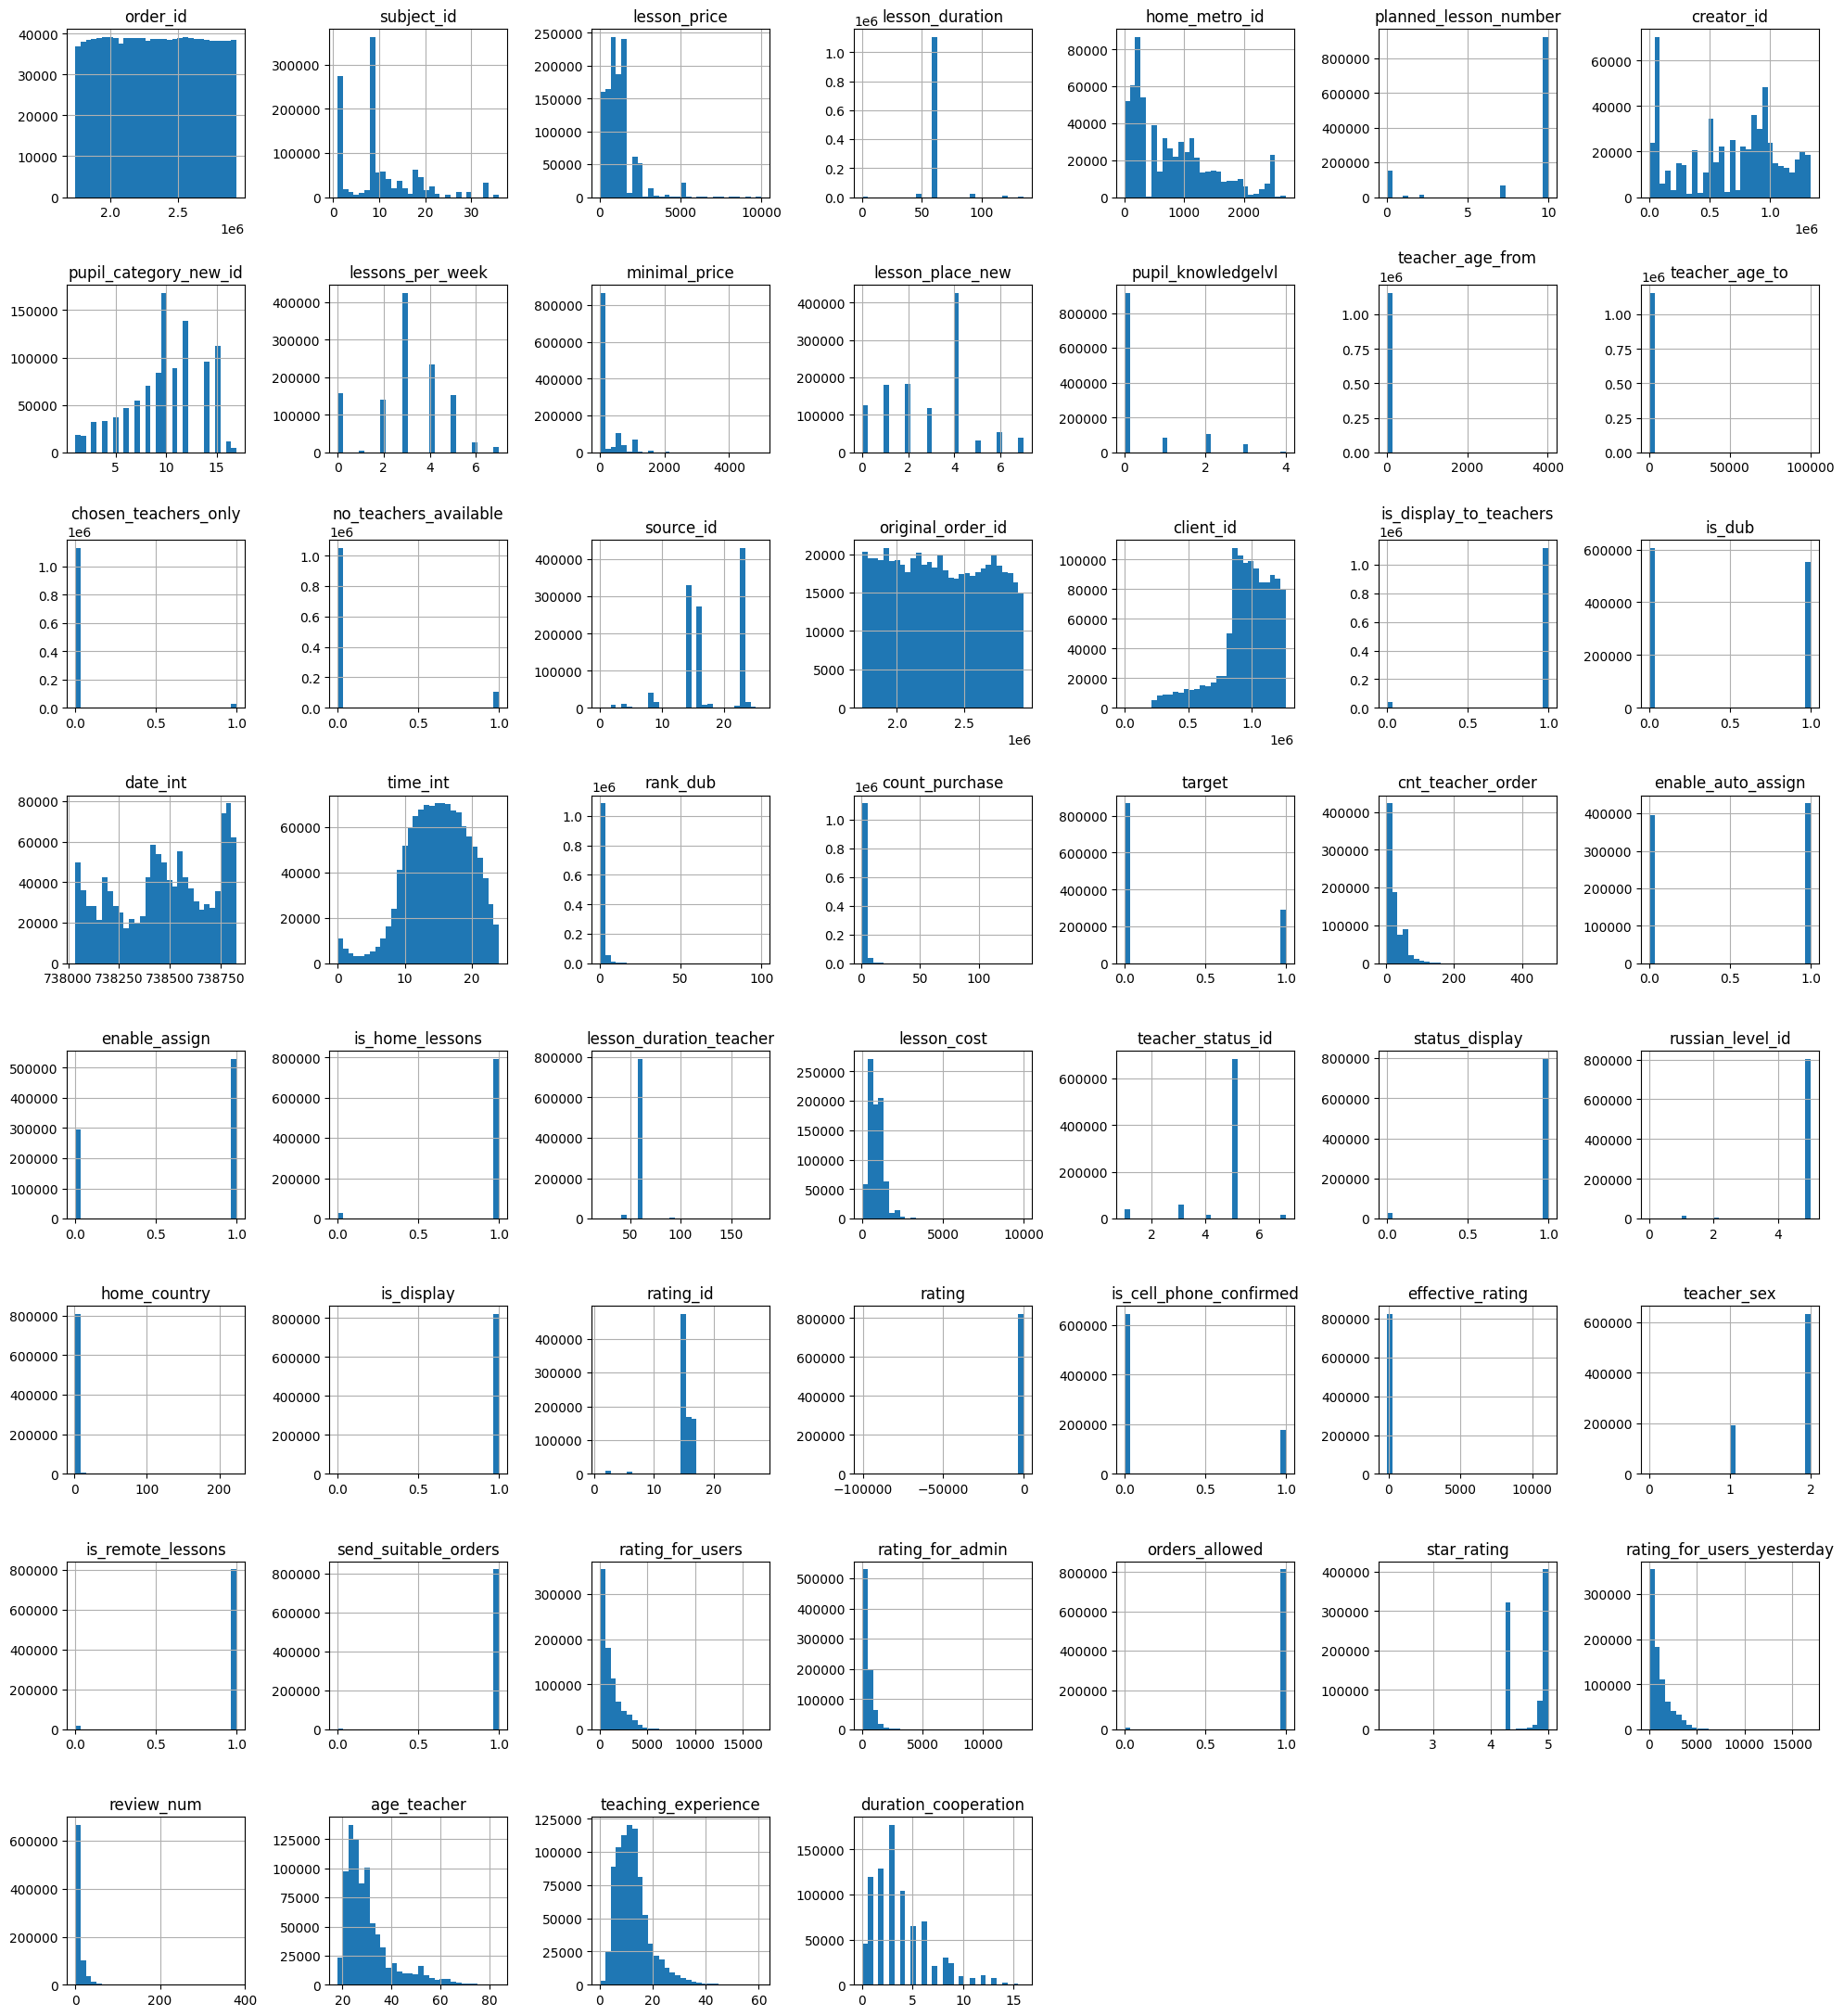

In [64]:
full_df.hist(figsize=(20, 22), bins=30)
plt.tight_layout();

# Разделение выборок

In [5]:
# создадим список категориальных столбцов
cat_col = full_df.columns[full_df.nunique() <= 330].tolist()
cat_col.remove('target')
# числовых
num_col = full_df.select_dtypes([np.number]).columns.tolist()
# текстовых
text_col = ['purpose', 'add_info']

In [6]:
# делим фрейм на трейн и тест
def train_test(data):
    df = data.copy()

    X = df.drop(columns=['order_id', 'target'])
    y = df['target']
    # разобьём сначала на обучающий и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=STATE, stratify=y)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = train_test(full_df)

(1042009, 53) (115779, 53) (1042009,) (115779,)


# Feature selection

**К сожалению не успел сделать(((**

# Обучение моделей и подбор гиперпараметров

In [8]:
# функция для заполнения пропусков
def fill_na(data):
    df = data.copy()
    # список столбцов с пропущеными значениями и минимальным значением 0
    col_0 = df.loc[:, df.isna().any() & (df.min() == 0)].columns
    df[col_0] = df[col_0].fillna(-1)
    df = df.fillna(0)

    return df

In [9]:
# Функция для перевода float в int, если значения являются целочисленными
def float_int(data):

    df = data.copy()
    # приведём к int столбцы с целыми числами, имеющими тип float
    is_float = df.select_dtypes(include=['float']).columns.tolist()
    is_int = df[is_float].apply(lambda x: x.astype(int) == x).all()
    int_col = is_int[is_int].index.tolist()
    df[int_col] = df[int_col].astype(int)

    return df

In [10]:
# функция лря обработки данных для LogisticRegression и ExtraTreesClassifier
def small_preorocessing_ET_LR(X_train, X_test):

    X_train_ET = X_train.copy()
    X_test_ET = X_test.copy()
    X_train_ET = X_train_ET.drop(columns=['purpose', 'add_info'])
    X_test_ET = X_test_ET.drop(columns=['purpose', 'add_info'])
    X_train_ET = fill_na(X_train_ET)
    X_test_ET = fill_na(X_test_ET)
    X_train_ET = float_int(X_train_ET)
    X_test_ET = float_int(X_test_ET)
    X_train_ET = reduce_mem_usage(X_train_ET)
    X_test_ET = reduce_mem_usage(X_test_ET)
    if X_train_ET.isnull().values.any() or X_test_ET.isnull().values.any():
        raise ValueError("Присутствуют пропущенные значения после предобработки данных")

    return X_train_ET, X_test_ET

In [11]:
X_train_ET, X_test_ET = small_preorocessing_ET_LR(X_train, X_test)

Оптимизируем данные...
До обработки памяти использовано 275.27 MB


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

После оптимизации памяти использовано: 114.28 MB
Использование памяти уменьшилось на 58.5%

Оптимизируем данные...
До обработки памяти использовано 30.59 MB


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

После оптимизации памяти использовано: 12.48 MB
Использование памяти уменьшилось на 59.2%



In [12]:
def crossvalidation(X_train, y_train, model=None):

    if model == 'LR':

        t0 = time()
        lr = LogisticRegression(random_state=STATE, class_weight='balanced')
        print('Идёт процесс перекрёстной проверки для логистической регрессии... Подождите...')
        scor = cross_val_score(lr, X_train_ET, y_train, cv=3, scoring='roc_auc')
        print(f'Время кроссвалидации {(time() - t0)/60:.2f} минут(ы).')
        print(f'ROC-AUС для логистической регрессии {scor.mean()} на кроссвалидации')

    if model == 'ET':

        t0 = time()
        et = ExtraTreesClassifier(random_state=STATE, class_weight='balanced')
        print('Идёт процесс перекрёстной проверки для ExtraTreesClassifier... Подождите...')
        scor = cross_val_score(et, X_train_ET, y_train, cv=3, scoring='roc_auc')
        print(f'Время кроссвалидации {(time() - t0)/60:.2f} минут(ы).')
        print(f'ROC-AUС для ExtraTreesClassifier {scor.mean()} на кроссвалидации')

    if model == 'CB':

        t0 = time()
        # изменим тип на category
        X_train[cat_col] = X_train[cat_col].astype(str).astype('category')
        model_CB = CatBoostClassifier(random_state=STATE,
                                      verbose=False,
                                      cat_features=cat_col,
                                      text_features=text_col)
        print('Идёт процесс перекрёстной проверки для CatBoostClassifier... Подождите...')
        scor = cross_val_score(model_CB, X_train, y_train, cv=3, scoring='roc_auc')
        print(f'Время кроссвалидации {(time() - t0)/60:.2f} минут(ы).')
        print(f'ROC-AUС для CatBoostClassifier {scor.mean()} на кроссвалидации')


In [74]:
# результат логистической регрессии
crossvalidation(X_train_ET, y_train, model='LR')

Идёт процесс перекрёстной проверки для логистической регрессии... Подождите...
Время кроссвалидации 0.92 минут(ы).
ROC-AUС для логистической регрессии 0.6728298946918363 на кроссвалидации


In [75]:
# результат ExtraTreesClassifier
crossvalidation(X_train_ET, y_train, model='ET')

Идёт процесс перекрёстной проверки для ExtraTreesClassifier... Подождите...
Время кроссвалидации 19.50 минут(ы).
ROC-AUС для ExtraTreesClassifier 0.8202998272601308 на кроссвалидации


In [13]:
# результат CatBoost
crossvalidation(X_train, y_train, model='CB')

Идёт процесс перекрёстной проверки для CatBoostClassifier... Подождите...
Время кроссвалидации 263.06 минут(ы).
ROC-AUС для CatBoostClassifier 0.7949378053252413 на кроссвалидации


# Тестирование модели

**Несморя на то, что для тестирования берётся одна модель, я всё-таки взял две)))**

In [13]:
def feature_importance_plot(X_train, model):
    # создадим фрейм важности признаков
    X_imp_CB = pd.DataFrame({'features': X_train.columns.tolist(),'feature_importance': model.feature_importances_})
    X_imp_CB = X_imp_CB.set_index('features')
    X_imp_CB = X_imp_CB.sort_values('feature_importance',ascending=False)
    # построим график важности
    plt.figure(figsize=(10, 14))
    sns.barplot(x=X_imp_CB['feature_importance'], y=X_imp_CB.index, order=X_imp_CB.sort_values('feature_importance', ascending=False).index)
    plt.title('Оценка важности признаков', fontsize=18)
    plt.xlabel('Важность признаков', fontsize=17)
    plt.ylabel('Признаки', fontsize=17)
    plt.tick_params(labelsize=15);

In [14]:
def roc_curve_plot(pred_proba):

    fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    #   установим границы осей от 0 до 1 >
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC-кривая', fontsize=20)
    plt.legend(('Тестируемая модель', 'Случайная модель'), loc='upper left');

In [15]:
def test_model(X_train, X_test, model=None):

    if model == 'ET':

        t0 = time()
        et = ExtraTreesClassifier(random_state=STATE, class_weight='balanced')
        print('Идёт процесс обучения ExtraTreesClassifier... Подождите...')
        et.fit(X_train_ET, y_train)
        pred_prob_et = et.predict_proba(X_test_ET)[:, 1]
        roc_auc = roc_auc_score(y_test, pred_prob_et)
        predict_et = et.predict(X_test_ET)
        print(f'Время обучения ExtraTreesClassifier {(time() - t0)/60:.2f} минут(ы).')
        print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(y_test == predict_et)}')
        print(classification_report(y_test, predict_et))
        feature_importance_plot(X_train_ET, et)
        cm = confusion_matrix(y_test, predict_et)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot();
        roc_curve_plot(pred_prob_et)

    if model == 'CB':

        t0 = time()
        X_train[cat_col] = X_train[cat_col].astype(str).astype('category')
        X_test[cat_col] = X_test[cat_col].astype(str).astype('category')
        model_CB = CatBoostClassifier(random_state=STATE,
                                      verbose=False,
                                      cat_features=cat_col,
                                      text_features=text_col)
        print('Идёт процесс обучения CatBoostClassifier... Подождите...')
        model_CB.fit(X_train, y_train)
        pred_prob_cb = model_CB.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, pred_prob_cb)
        predict_cb = model_CB.predict(X_test)
        print(f'Время обучения CatBoostClassifier {(time() - t0)/60:.2f} минут(ы).')
        print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(y_test == predict_cb)}')
        print(classification_report(y_test, predict_cb))
        feature_importance_plot(X_train, model_CB)
        cm = confusion_matrix(y_test, predict_cb)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot();
        fpr, tpr, thresholds = roc_curve(y_test, predict_cb)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='CatBoostClassifier')
        display.plot();
        roc_curve_plot(pred_prob_cb)


Идёт процесс обучения ExtraTreesClassifier... Подождите...
Время обучения ExtraTreesClassifier 9.43 минут(ы).
AUC-ROC на тестовых данных: 0.8405485910903426, accuracy 0.8145086760120575
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     86712
           1       0.82      0.33      0.47     29067

    accuracy                           0.81    115779
   macro avg       0.82      0.65      0.68    115779
weighted avg       0.82      0.81      0.78    115779



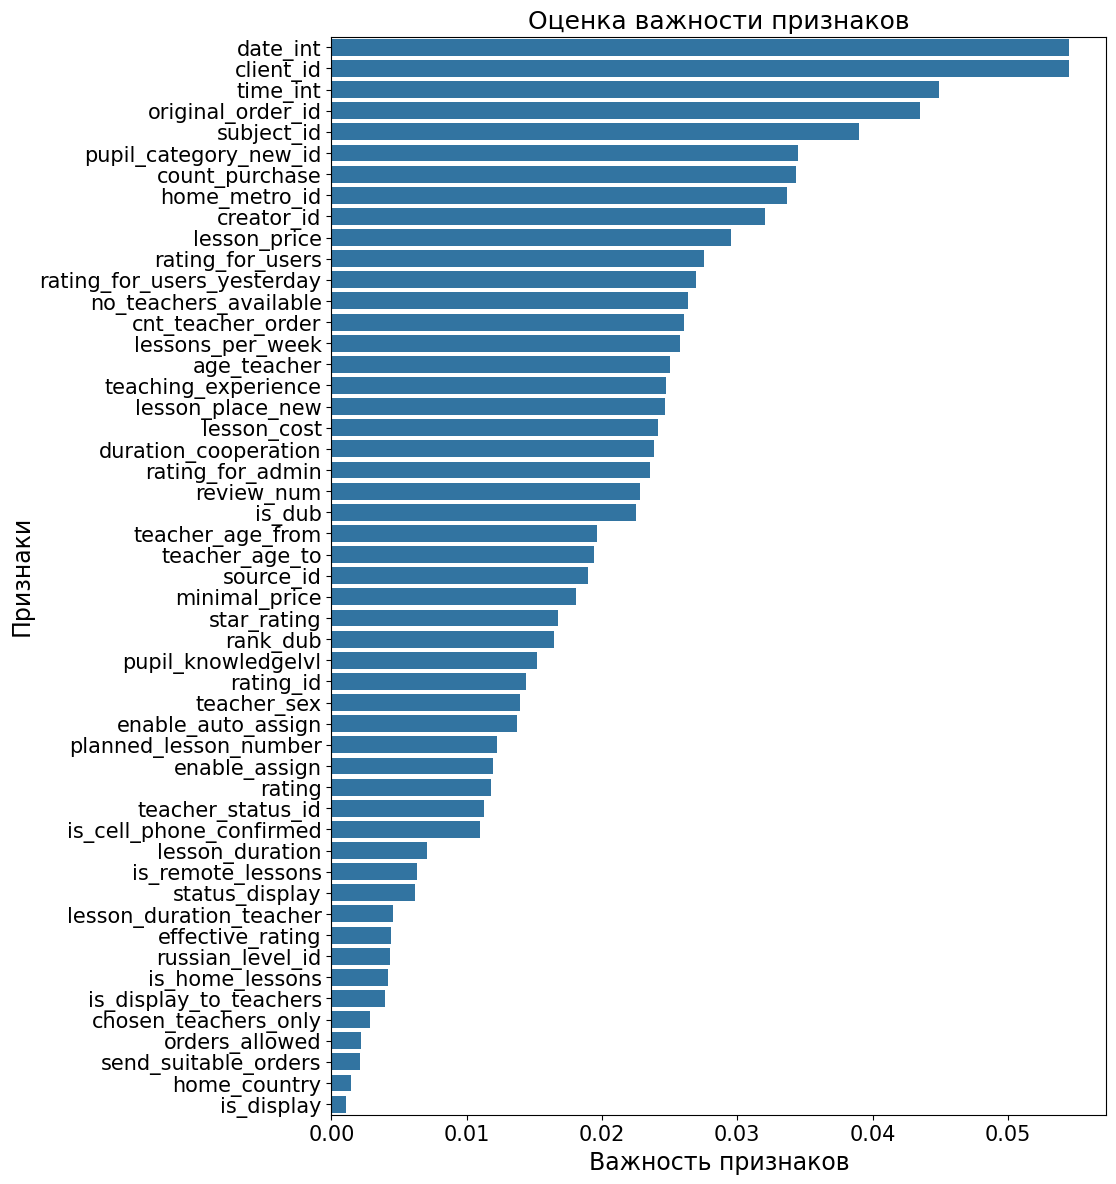

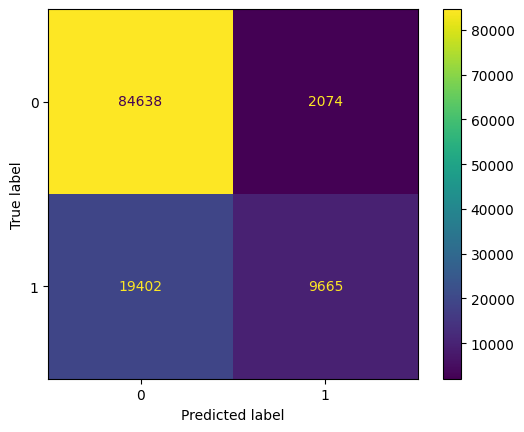

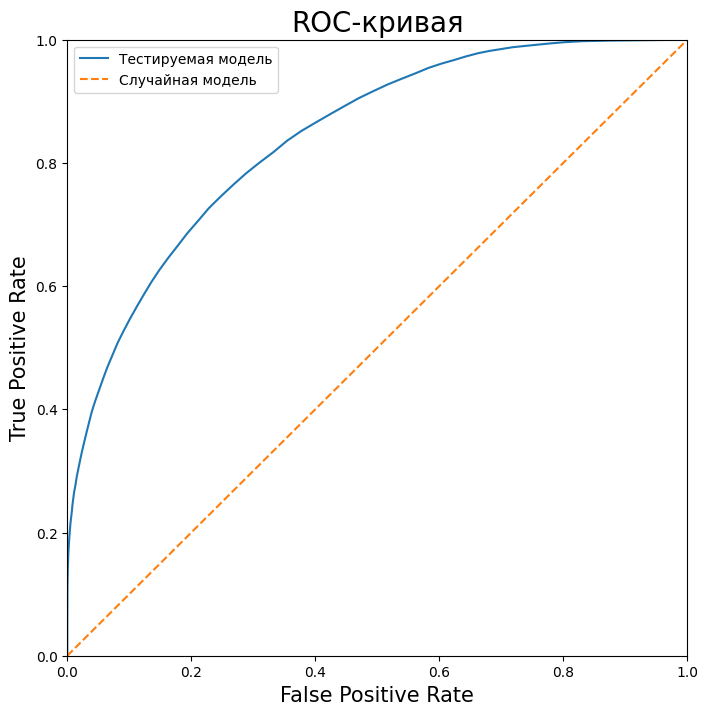

In [16]:
test_model(X_train_ET, X_test_ET, model='ET')

**Учитывая, что были обсуждения относительно удаления столбца client_id, я посчитал без него. Метрика roc_auc для ExtraTreesClassifier составила 0,7963113068424348.**

Идёт процесс обучения CatBoostClassifier... Подождите...
Время обучения CatBoostClassifier 124.00 минут(ы).
AUC-ROC на тестовых данных: 0.8087684942163187, accuracy 0.7982362950103213
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     86712
           1       0.73      0.31      0.43     29067

    accuracy                           0.80    115779
   macro avg       0.77      0.64      0.66    115779
weighted avg       0.79      0.80      0.77    115779



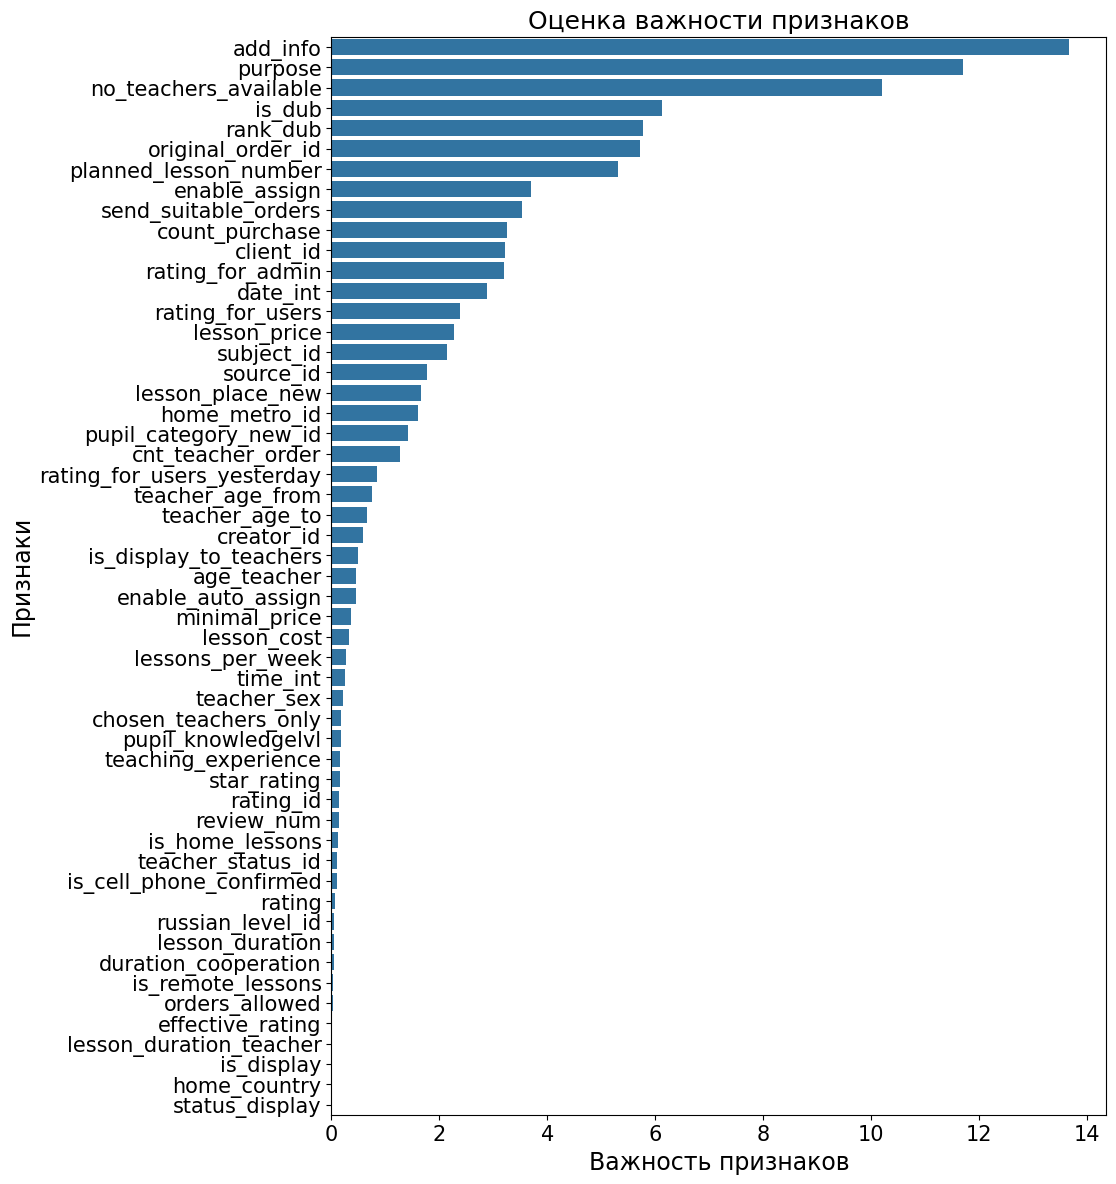

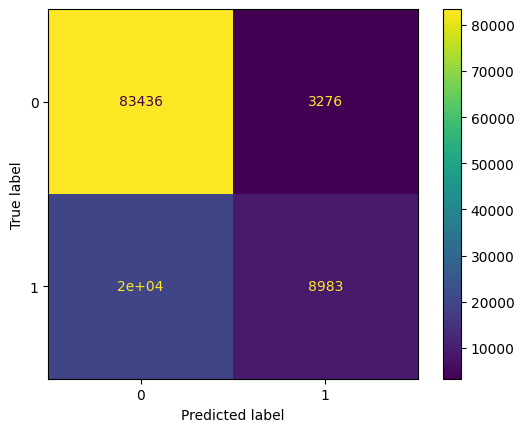

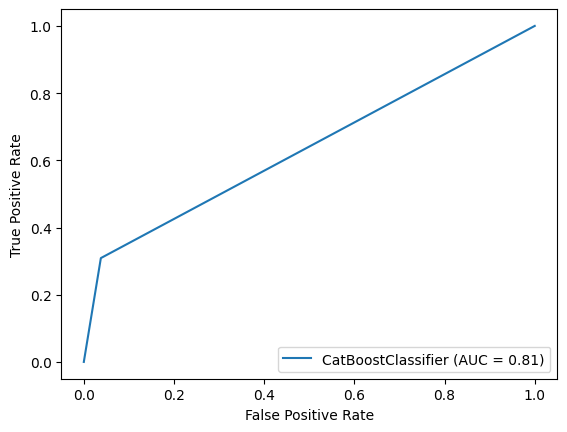

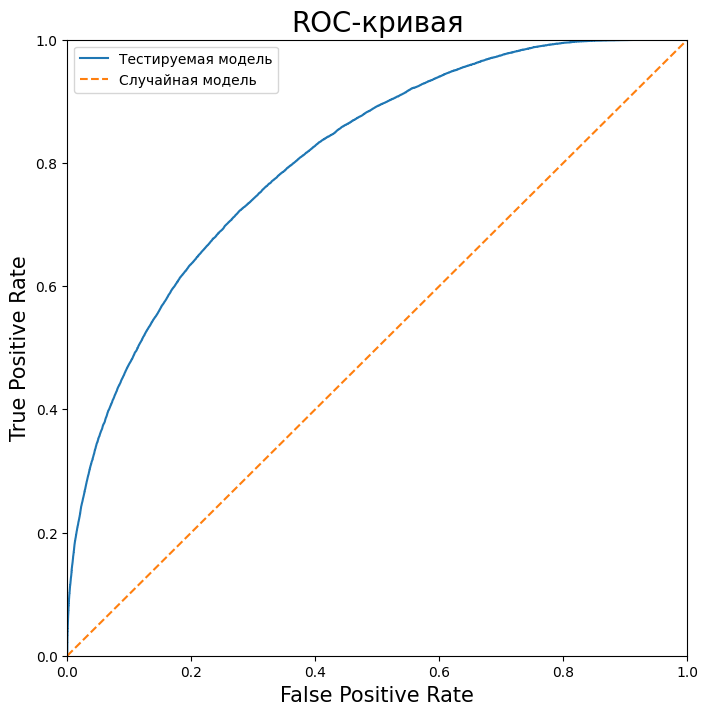

In [17]:
test_model(X_train, X_test, model='CB')

**На Catboost без client_id - 0,7951337292506074.**

# Что не успел:

**К сожалению ОЧЕНЬ много не успел(((**
- не сделан Feature selection   
- не произведён подбор гиперпараметров   
- толком не произедён анализ  
- не реализована общая функция (для запуска всего проекта)    
- не сделано масштабирование и кодирование признаков  
- не реализованы методы NLP     
- не реализованы трансформеры и пайплайн   
- не устранена коллинеарность для линейных моделей   
- сделать калибровку вероятностей
- не сделал Docker-контейнер